# Default training Parameters:

In [2]:
from RLTrain import Opt
import os
import time
print(Opt())
import pandas as pd
from RadarGraph import *

policy                        			MlpPolicy
algorithm                     			PPO
environment                   			WurtzReact-v1
steps                         			500
dir                           			<DEFAULT>
seed                          			None



# Training an agent with default parameters

In [ ]:
t=time.time()
os.system("python RLTrain.py steps=200000")
print(time.time()-t)

# Running inference with the trained models and saving [S,A,R,S] info

In [3]:
os.system("python RLTest.py PPO_WurtzReact-v1 steps=500")
os.system("python RLTest.py WRH algorithm=WRH steps=500")

0

# Gathering some Heuristics

In [1]:
import pandas as pd
ppo = pd.read_pickle("PPO_WurtzReact-v1/rollout")
heuristic = pd.read_pickle("WRH/rollout")

print(ppo.keys())

info = [
    ['dT', 'dV', '1-chlorohexane', '2-chlorohexane', '3-chlorohexane', 'Na' ],
    ('PPO', [
        [a for a in ppo.Action.mean()],
        [ppo[ppo.Done==True].Reward.mean()]*6,
        [1,0,0,0,0,0]]),
    ('Heuristic', [
        [a for a in heuristic.Action.mean()],
        [heuristic[heuristic.Done==True].Reward.mean()]*6,
        [1,0,0,0,0,0]]),

]

Index(['InState', 'Action', 'Reward', 'OutState', 'Done', 'Info', 'Step'], dtype='object')


In [2]:
print(heuristic[heuristic.Done==True].Reward.mean())

print(ppo[ppo.Done==True].Reward.mean())

0.30924475341993485
0.3080756079493899


# Plot as a Radar Graph

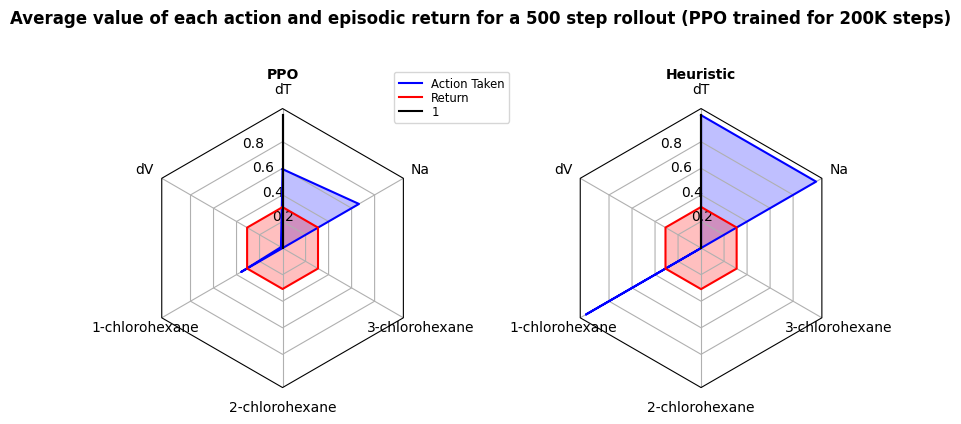

In [3]:
from RadarGraph import *


theta = radar_factory(len(info[0]), frame='polygon')


fig, axs = plt.subplots(figsize=(9, 9), nrows=1, ncols=2,subplot_kw=dict(projection='radar'))
fig.subplots_adjust(wspace=0.5, hspace=0.25, top=0.85, bottom=0.05)

make_radar(theta,axs,info,colors = "brk")

labels = ('Action Taken', 'Return', '1', 'Factor 4', 'Factor 5')
legend = axs[0].legend(labels, loc=(0.9, .95),labelspacing=0.1, fontsize='small')


fig.text(0.5, 0.7, "Average value of each action and episodic return for a 500 step rollout (PPO trained for 200K steps)",
             horizontalalignment='center', color='black', weight='bold',
             size='large')

plt.show()

# Functions for Conditional Returns and Actions

In [7]:
import sys
sys.path.append('../')

from chemistrylab.reactions.available_reactions.chloro_wurtz import PRODUCTS as CWtargs

def get_conditional_rewards(frame,targets=CWtargs):
    """
    Gives returns conditioned on the different targets
    Inputs:
        Frame (dataframe) - Pandas Dataframe containing gym information
        targets (list) - List of N targets (reaction products)
        
    Outputs:
        targets
        rew (List<float>) - List of size N containing the average return given each target
    
    """
    # turn observation column into a numpy array
    obs = np.stack(frame.InState)
    N=len(targets)
    rew=[]
    for i in range(N):
        #gather all data where the target is targets[N]
        cframe=frame[obs[:,-N+i]>0.9]
        #Obtain the mean reward of these episodes
        rew+=[cframe[cframe.Done==True].Reward.mean()]
    return [targets,rew]

def get_conditional_actions(frame,targets=CWtargs):
    """
    Gives actions conditioned on the different targets, meant for continuous action spaces
    Inputs:
        Frame (dataframe) - Pandas Dataframe containing gym information
        targets (list) - List of N targets (reaction products)
        
    Outputs:
        targets
        act (List<array>) - List of size N containing the mean action given each target
    
    """
    # turn observation column into a numpy array
    obs = np.stack(frame.InState)
    N=len(targets)
    act=[]
    for i in range(N):
        #gather all data where the target is targets[N]
        cframe=frame[obs[:,-N+i]>0.9]
        #Obtain the mean action of these episodes
        act+=[cframe.Action.mean()]
    return [targets,act]

# General Wurtz React:

In [8]:
import pandas as pd

models = ["A2C","PPO","SAC"]

gppo = [pd.read_pickle("%s_GenWurtzReact-v1/rollout"%model) for model in models]
gheuristic = pd.read_pickle("GWRH/rollout")

In [9]:
info = ([get_conditional_rewards(gheuristic)[0]]+
        
[(models[i], [get_conditional_rewards(gppo[i])[1]]) for i in range(len(models))]+

[('Heuristic', [get_conditional_rewards(gheuristic)[1]])])

In [14]:
gppo[1][gppo[1].Done==True].Reward.mean()

0.6778623075756693

In [16]:
gheuristic[gheuristic.Done==True].Reward.mean()

0.6440679305115823

In [10]:
print(info)

[['dodecane', '5-methylundecane', '4-ethyldecane', '5,6-dimethyldecane', '4-ethyl-5-methylnonane', '4,5-diethyloctane', 'NaCl'], ('A2C', [[0.18766186671757637, 0.10517452206662536, 0.16366714031812465, 0.3474141778883154, 0.07250152907067929, 0.19616785856284696, 2.112313109121933]]), ('PPO', [[0.45358591058777253, 0.2773050193095835, 0.27749124562028993, 0.45367918626641807, 0.2774412603439118, 0.45402352603040375, 2.1790564316093515]]), ('SAC', [[0.4009449988153402, 0.17706682096959125, 0.2759214600417885, 0.3529939858234867, 0.2742395716344013, 0.44702915728637344, 2.1402971610111776]]), ('Heuristic', [[0.453587464629671, 0.27731177828970616, 0.2775080385058111, 0.45368713672194444, 0.2775282292161147, 0.4540260350866713, 2.179061995357985]])]


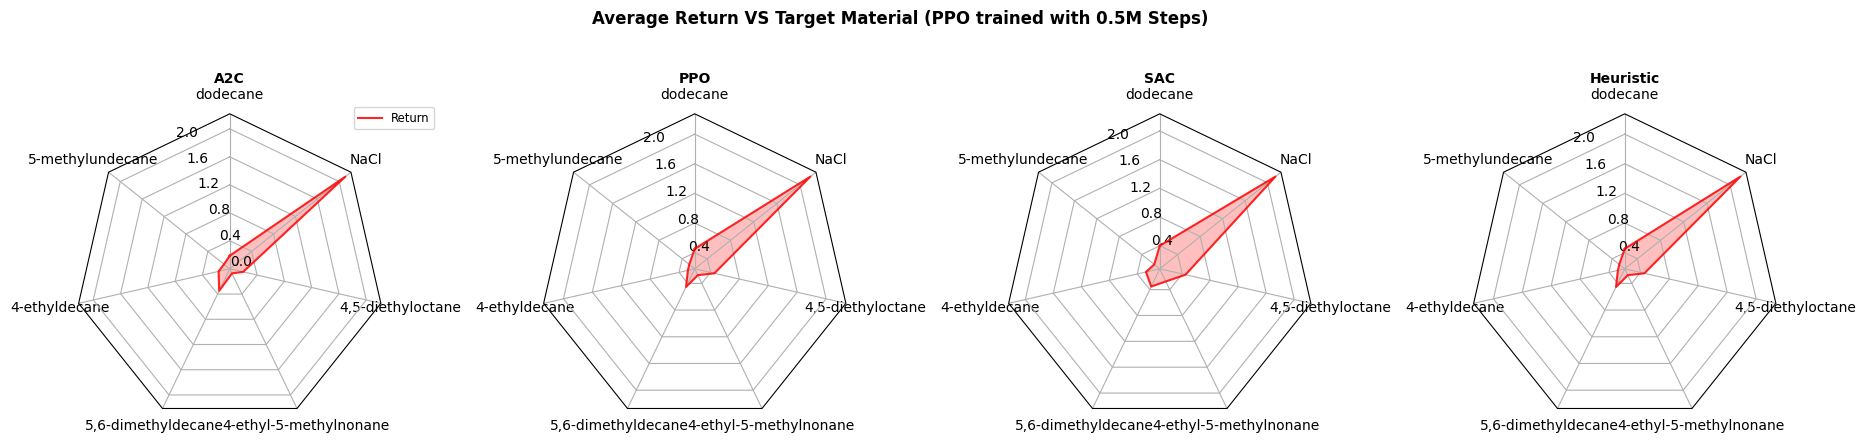

In [11]:
from RadarGraph import *


theta = radar_factory(len(info[0]), frame='polygon')

fig, axs = plt.subplots(figsize=(22, 7), nrows=1, ncols=len(models)+1,subplot_kw=dict(projection='radar'))
fig.subplots_adjust(wspace=0.5, hspace=0.25, top=0.85, bottom=0.05)

make_radar(theta,axs,info,colors = "r",gridlines=[0.0,0.4,0.8,1.2,1.6,2.0])

labels = ('Return', '-', '1', 'Factor 4', 'Factor 5')
legend = axs[0].legend(labels, loc=(0.9, .95),labelspacing=0.1, fontsize='small')


fig.text(0.5, 0.8, "Average Return VS Target Material (PPO trained with 0.5M Steps)",
             horizontalalignment='center', color='black', weight='bold',
             size='large')

plt.show()

In [6]:
info0 = ([
    ['dT', 'dV', '1-chlorohexane', '2-chlorohexane', '3-chlorohexane', 'Na' ]]+
    [(models[i], [[b for b in act] for act in get_conditional_actions(gppo[i])[1]]) for i in range(len(models))]+
    [('Heuristic', [[b for b in act] for act in get_conditional_actions(gheuristic)[1]])]

)

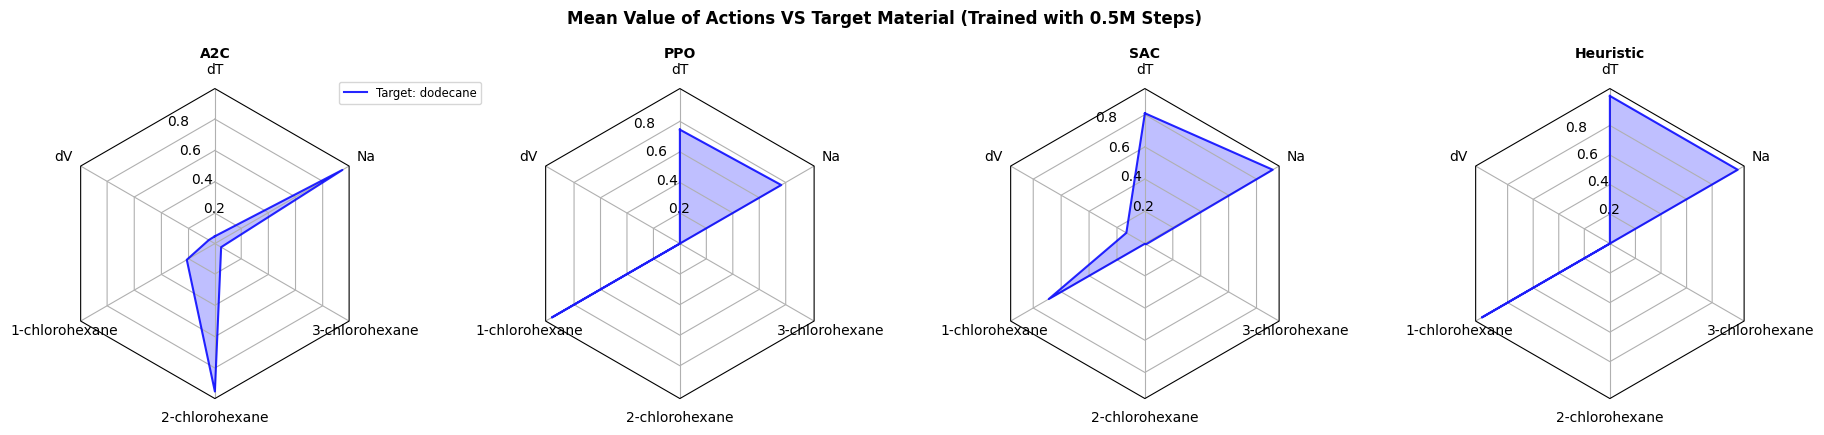

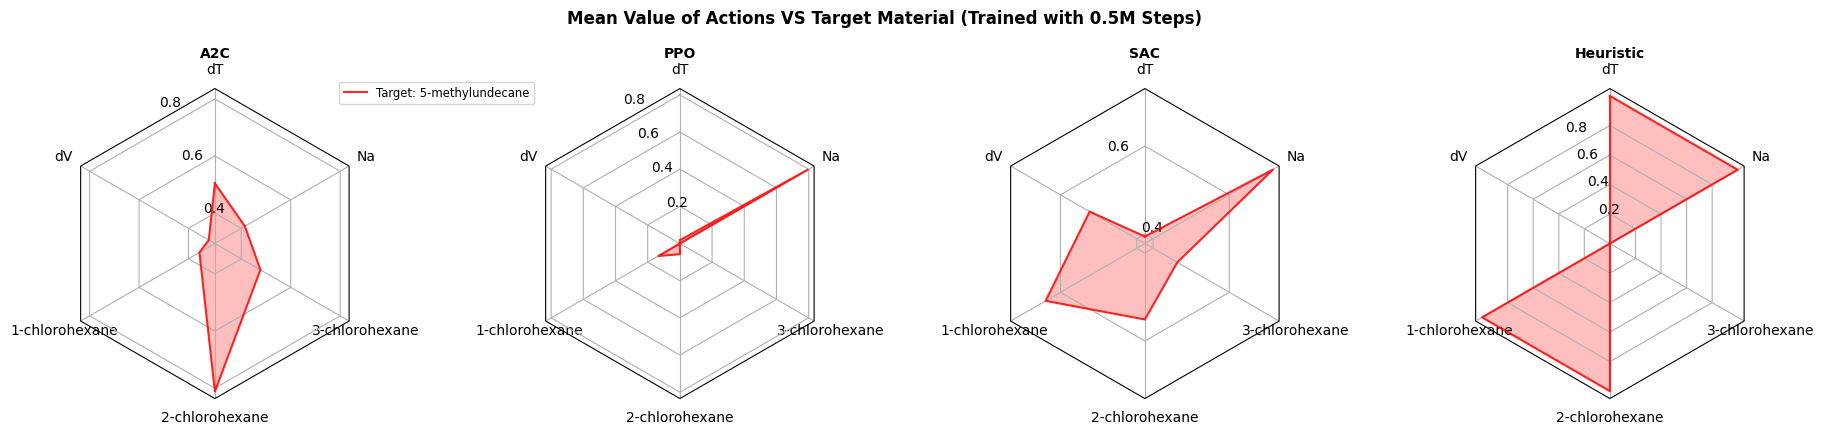

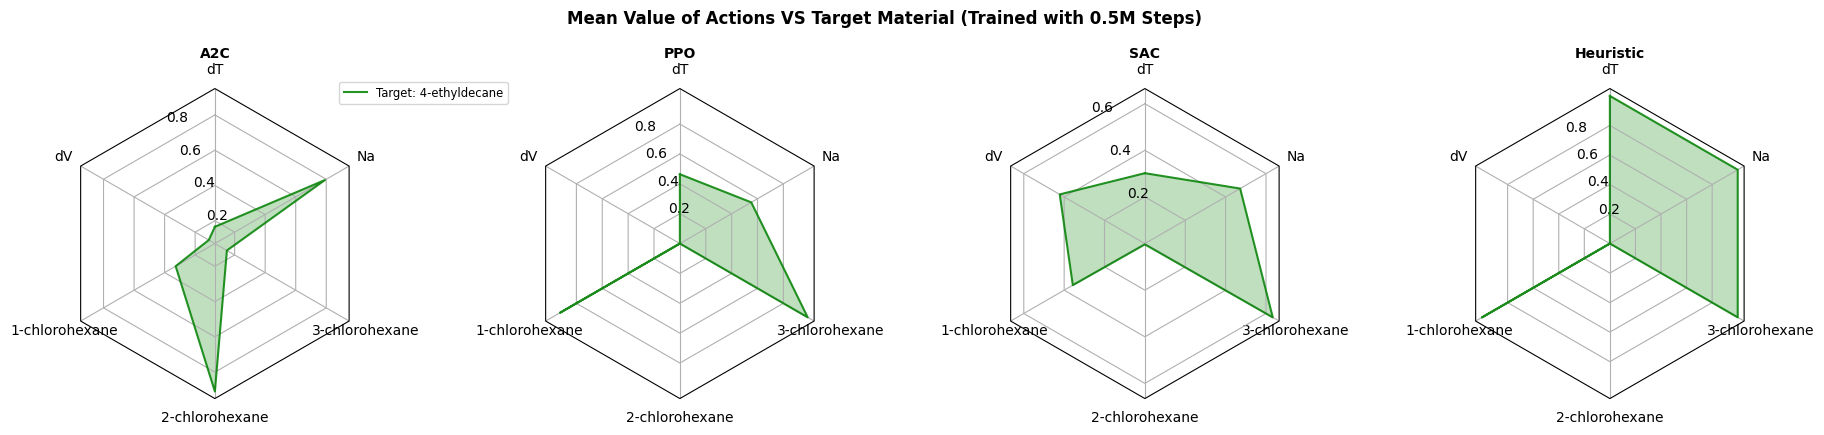

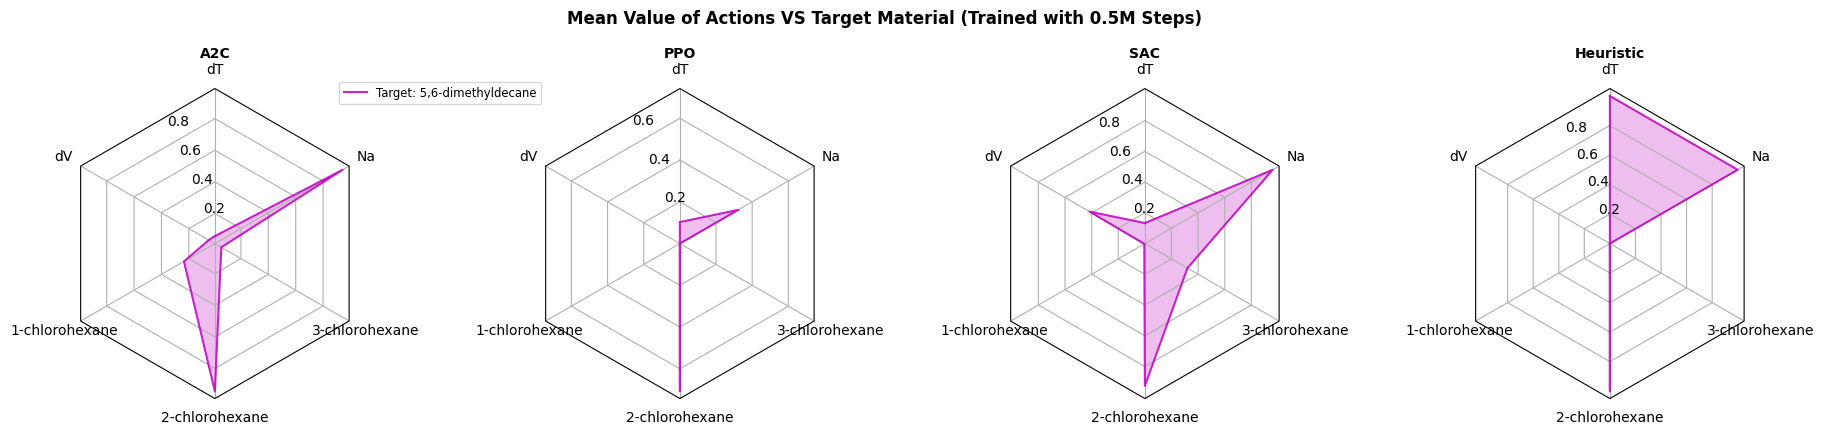

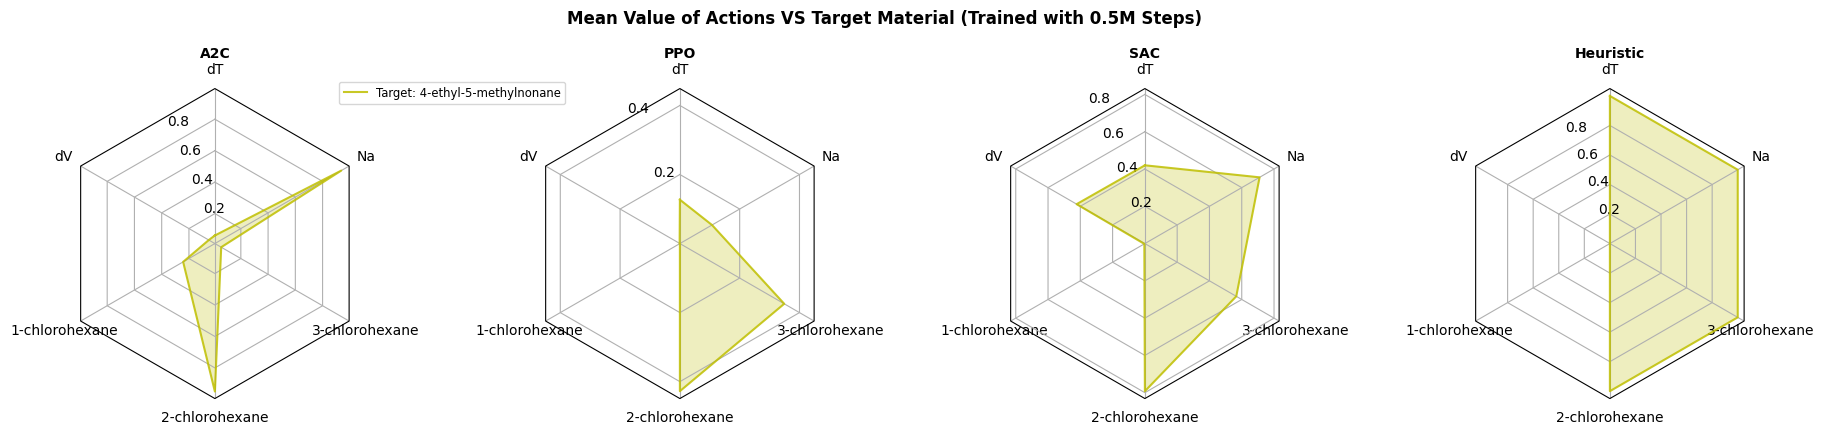

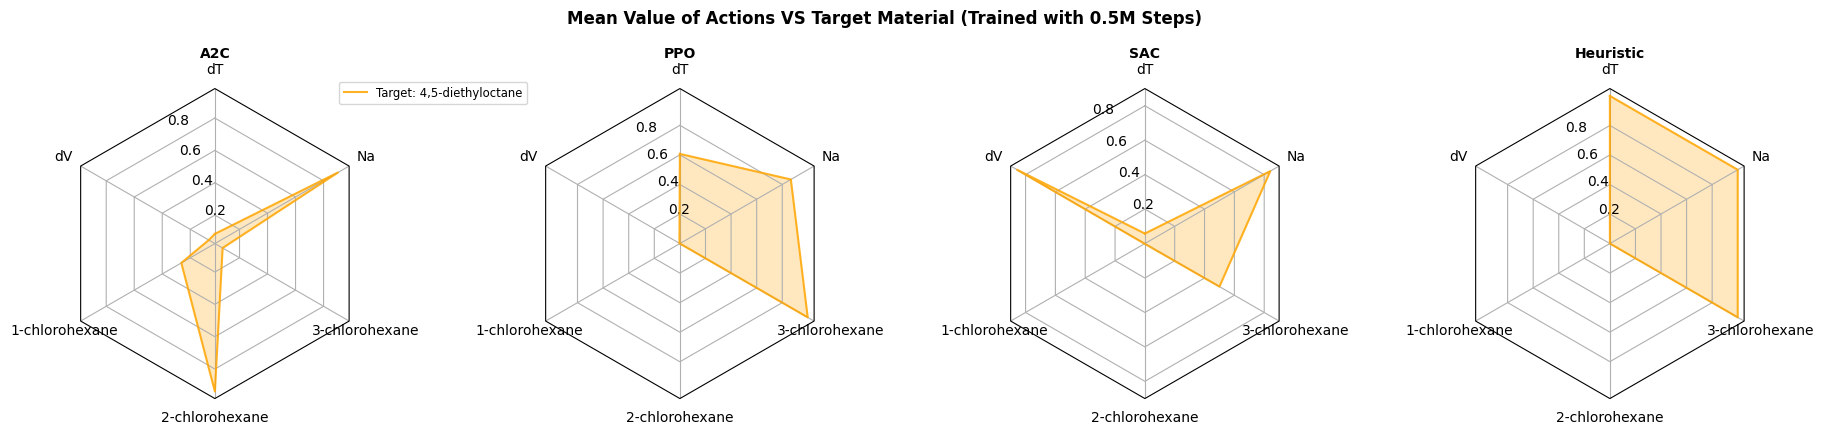

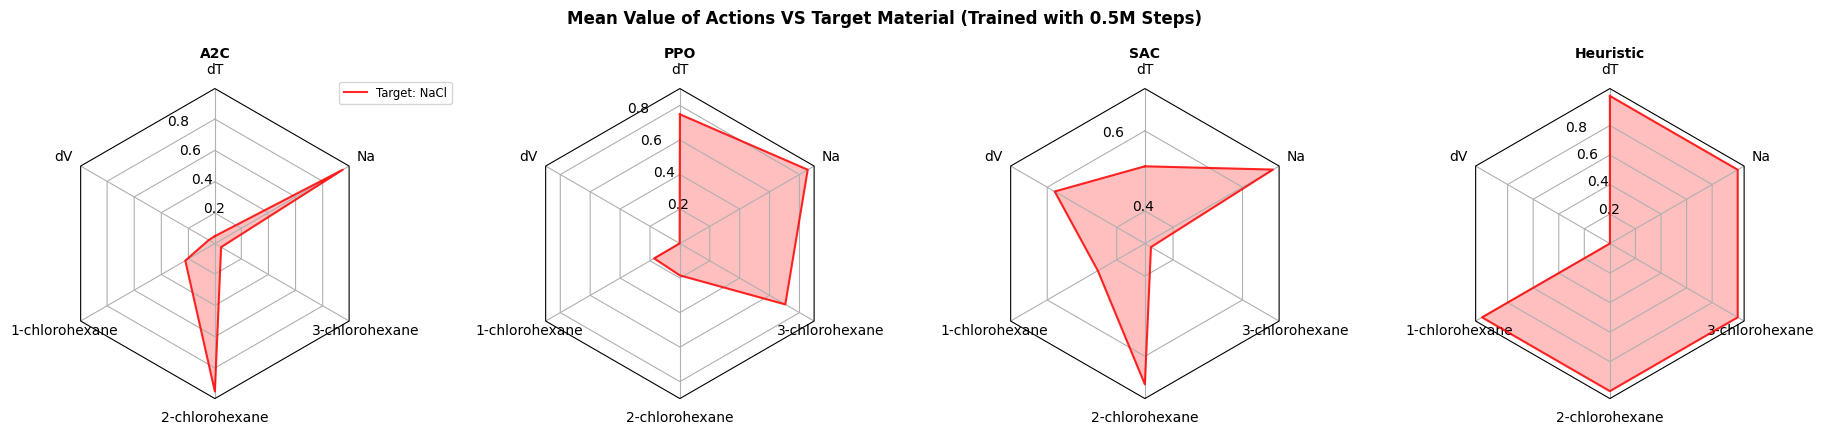

In [7]:
for i in range(len(CWtargs)):
    
    info=[info0[0]]+[(md[0],md[1][i:i+1]) for md in info0[1:]]


    theta = radar_factory(len(info[0]), frame='polygon')
    fig, axs = plt.subplots(figsize=(22, 4), nrows=1, ncols=len(models)+1,subplot_kw=dict(projection='radar'))
    fig.subplots_adjust(wspace=0.5, hspace=0.25, top=0.85, bottom=0.05)
    c=['b', 'r', 'g', 'm', 'y',"orange","r"][i:i+1]
    make_radar(theta,axs,info,colors=c)
    labels = ["Target: "+CWtargs[i]]
    legend = axs[0].legend(labels, loc=(0.9, .95),labelspacing=0.1, fontsize='small')
    fig.text(0.5, 1.0, "Mean Value of Actions VS Target Material (Trained with 0.5M Steps)",
                 horizontalalignment='center', color='black', weight='bold',
                 size='large')
    plt.show()

# Fict React:

Reactions at play:

A+B $\rightarrow$ E</br>
A+D $\rightarrow$ F</br>
B+D $\rightarrow$ G</br>
F+G $\rightarrow$ I</br>

In [9]:
from chemistrylab.reactions.available_reactions.fict_react2 import PRODUCTS as FRtargs
from chemistrylab.reactions.available_reactions.fict_react2 import REACTANTS as FRchoices

models = ["A2C","PPO","SAC"]

fppo = [pd.read_pickle("%s_FictReact-v2/rollout"%model) for model in models]

fheuristic = pd.read_pickle("FR2H/rollout")

In [10]:
info = ([get_conditional_rewards(fheuristic,FRtargs)[0]]+
[(models[i], [get_conditional_rewards(fppo[i],FRtargs)[1]]) for i in range(len(models))]+
[('Heuristic', [get_conditional_rewards(fheuristic,FRtargs)[1]])])

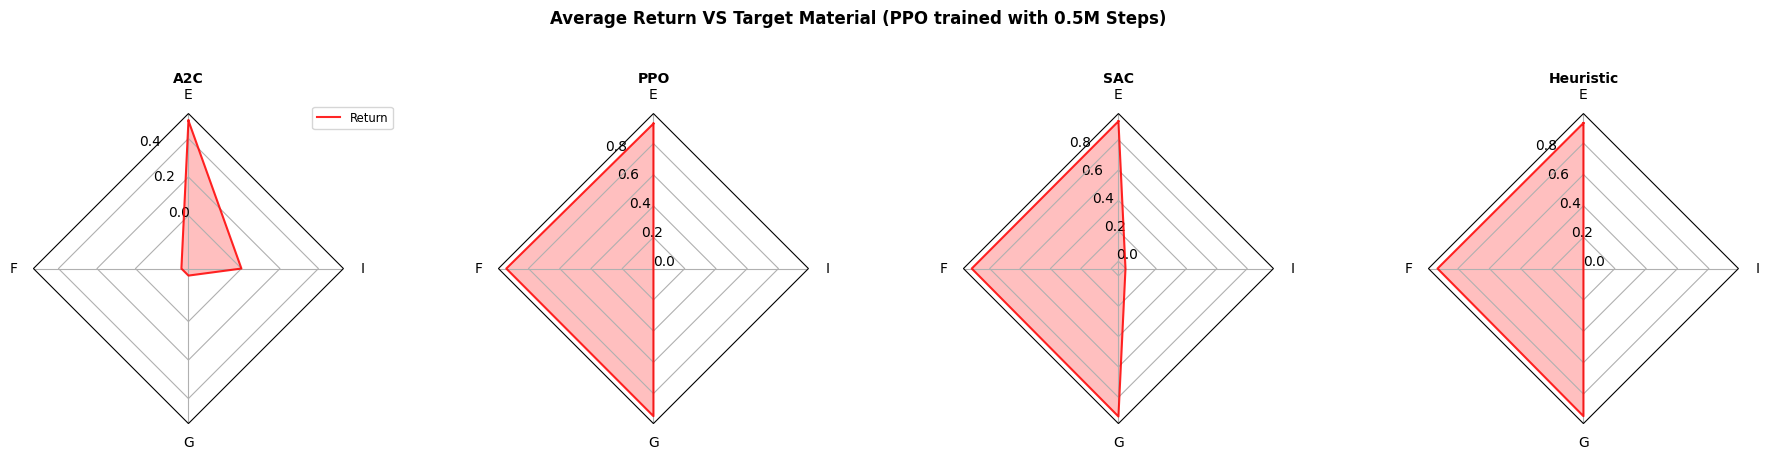

In [11]:
theta = radar_factory(len(info[0]), frame='polygon')

fig, axs = plt.subplots(figsize=(22, 7), nrows=1, ncols=len(models)+1,subplot_kw=dict(projection='radar'))

#axs = np.array([axs])

fig.subplots_adjust(wspace=0.5, hspace=0.25, top=0.85, bottom=0.05)

make_radar(theta,axs,info,colors = "r",gridlines=[0.0,0.2,0.4,0.6,0.8])

labels = ('Return', '-', '1', 'Factor 4', 'Factor 5')
legend = axs[0].legend(labels, loc=(0.9, .95),labelspacing=0.1, fontsize='small')


fig.text(0.5, 0.8, "Average Return VS Target Material (PPO trained with 0.5M Steps)",
             horizontalalignment='center', color='black', weight='bold',
             size='large')

plt.show()

In [12]:
info0 = ([
    ['dT', 'dV']+FRchoices]+
    [(models[i], [[b for b in act] for act in get_conditional_actions(fppo[i],FRtargs)[1]]) for i in range(len(models))]+
    [('Heuristic', [[b for b in act] for act in get_conditional_actions(fheuristic,FRtargs)[1]])]

)

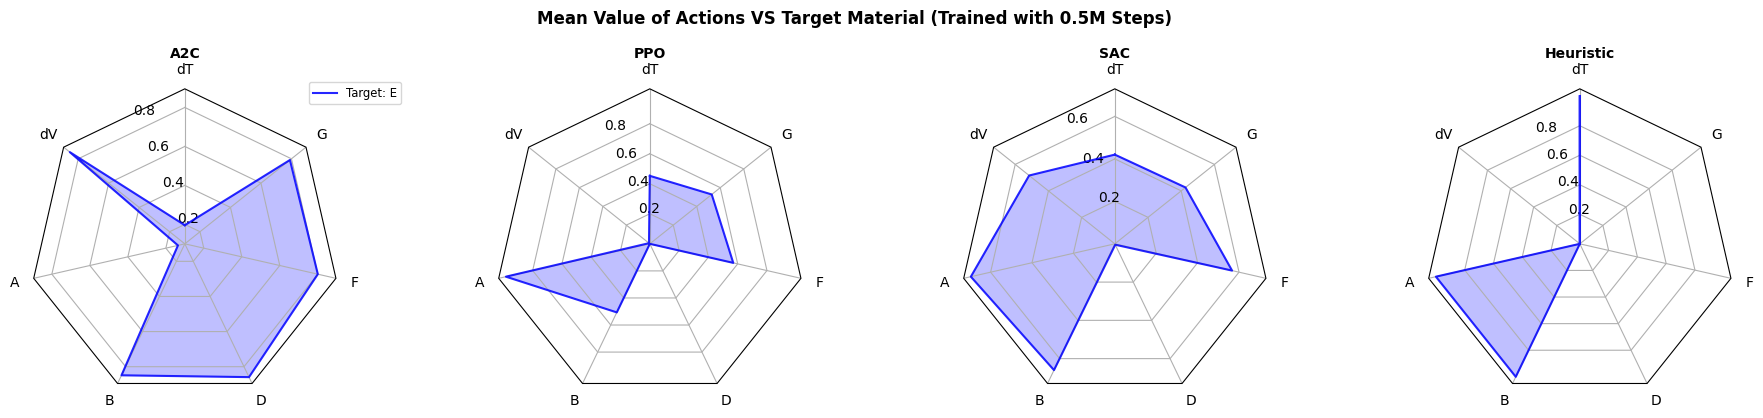

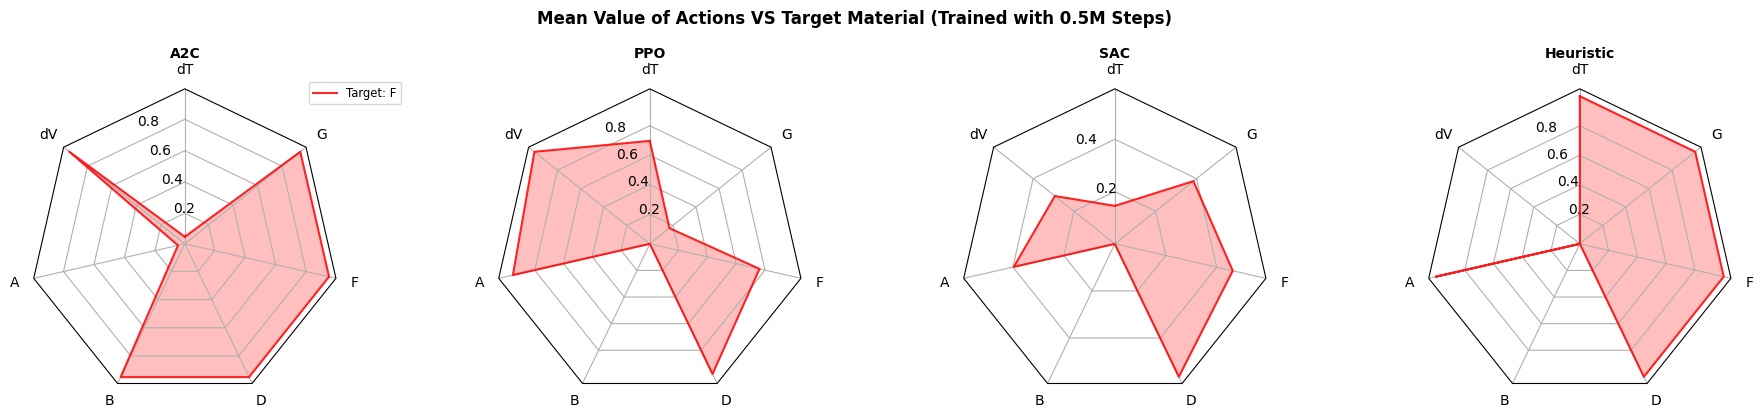

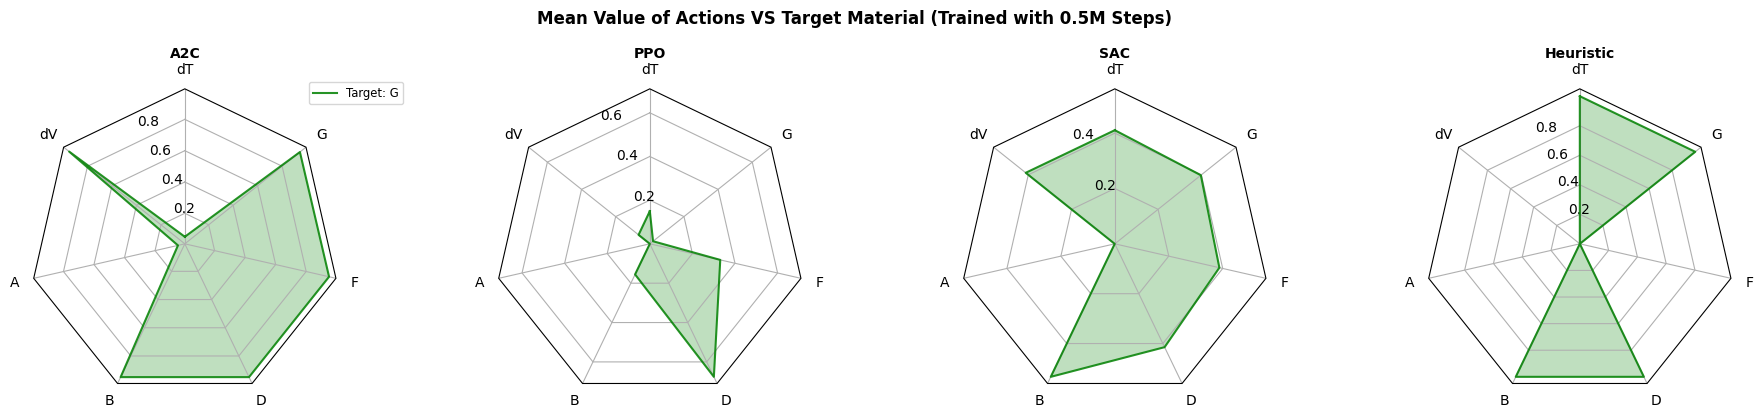

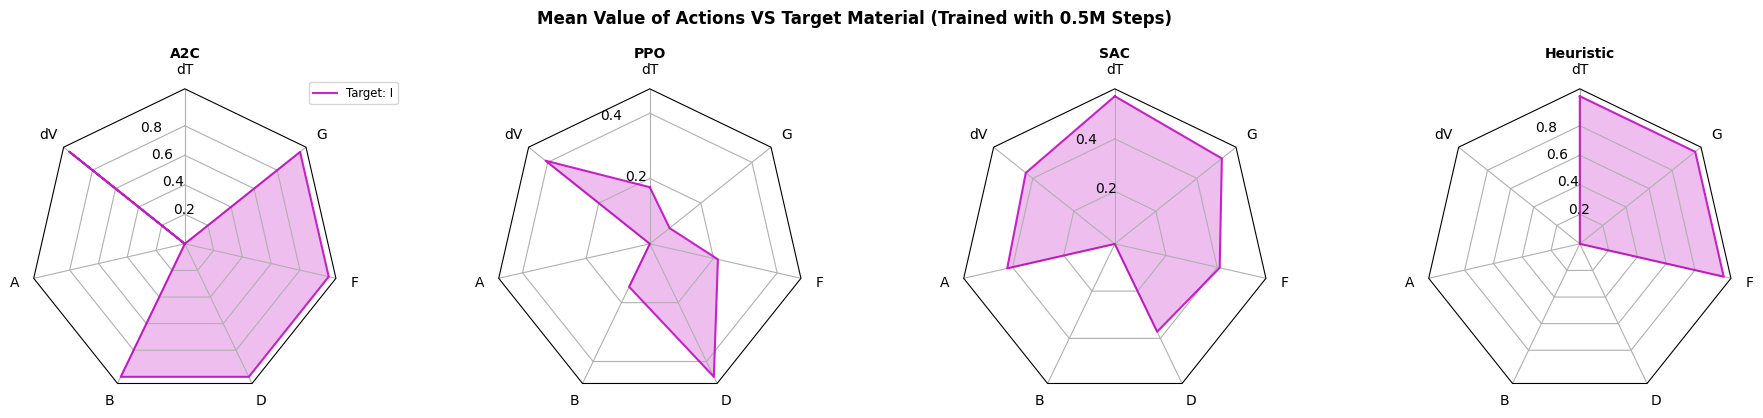

In [13]:
for i in range(len(FRtargs)):
    
    info=[info0[0]]+[(md[0],md[1][i:i+1]) for md in info0[1:]]


    theta = radar_factory(len(info[0]), frame='polygon')
    fig, axs = plt.subplots(figsize=(22, 4), nrows=1, ncols=len(models)+1,subplot_kw=dict(projection='radar'))
    fig.subplots_adjust(wspace=0.5, hspace=0.25, top=0.85, bottom=0.05)
    c=['b', 'r', 'g', 'm', 'y',"orange","r"][i:i+1]
    make_radar(theta,axs,info,colors=c)
    labels = ["Target: "+FRtargs[i]]
    legend = axs[0].legend(labels, loc=(0.9, .95),labelspacing=0.1, fontsize='small')
    fig.text(0.5, 1.0, "Mean Value of Actions VS Target Material (Trained with 0.5M Steps)",
                 horizontalalignment='center', color='black', weight='bold',
                 size='large')
    plt.show()

# Handling Box-Discrete actions

In [4]:
def get_discrete_actions(frame,N=None):
    """
    Gives distribution of actions (index 0) taken as well as the average value of the actions at index 1
    Inputs:
        Frame (dataframe) - Pandas Dataframe containing gym information        
    Outputs:
        act0 (list<float>) - Action (index 0) distribution
        act1 (list(float)) - Average action at index 1
    
    """
    # turn observation column into a numpy array
    act = np.stack(frame.Action)    
    if N is None:
        N = np.max(act[:,0])
    N0= np.max(act[:,1])
    act0=[]
    act1=[]
    #print(N)
    for i in range(N+1):
        #gather all data where the target is targets[N]
        cframe=frame[act[:,0]==i]
        
        #print(cframe)
        #Obtain the mean action of these episodes
        act0+=[len(cframe.Action)/act.shape[0]]
        if len(cframe.Action)==0:
            act1+=[0]
        else:
            act1+=[cframe.Action.mean()[1]/N0]
    return [act0,act1]

# Distillation Bench Results

In [5]:
models = ["A2C","PPO"]
dppo = [pd.read_pickle("%s_WurtzDistill-v1/rollout"%model) for model in models]
dheuristic = pd.read_pickle("WDH/rollout")
#dheuristic = pd.read_pickle("FR2H/rollout")

In [6]:
info = ([['dT', 'Pour 0->1', 'Pour 1->2', 'Wait', 'End Experiment' ]]+
[(models[i], get_discrete_actions(dppo[i],N=4)[::-1]+
 [[dppo[i][dppo[i].Done==True].Reward.mean()]*5]
 ) for i in range(len(models))]+
[('Heuristic', get_discrete_actions(dheuristic,N=4)[::-1]
+[[dheuristic[dheuristic.Done==True].Reward.mean()]*5])])

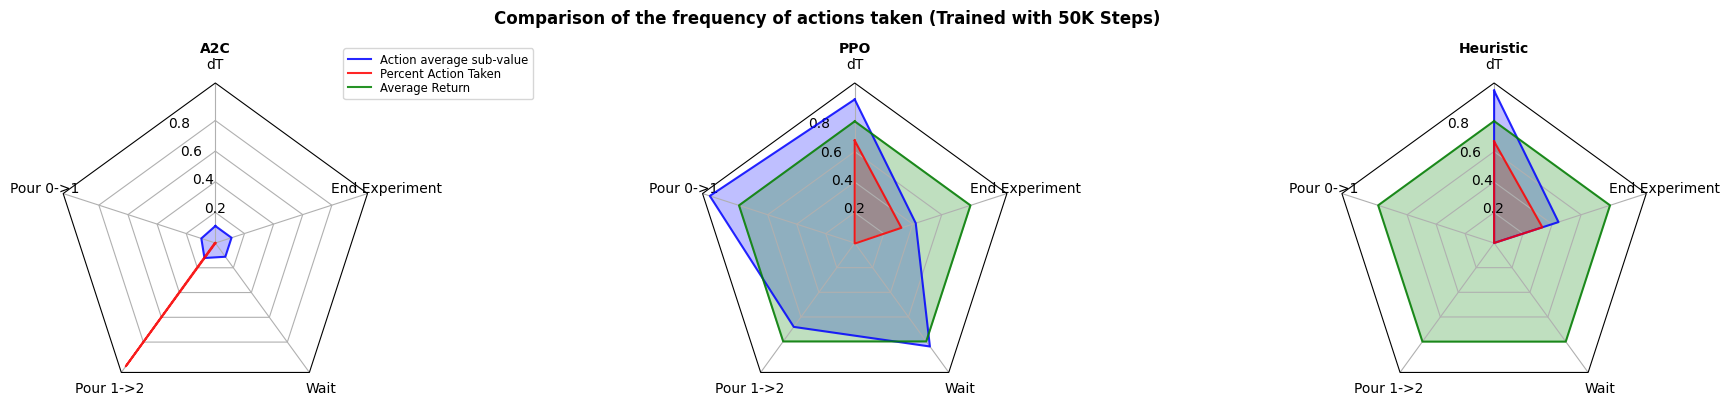

In [7]:
theta = radar_factory(len(info[0]), frame='polygon')
fig, axs = plt.subplots(figsize=(22, 4), nrows=1, ncols=len(models)+1,subplot_kw=dict(projection='radar'))
fig.subplots_adjust(wspace=0.5, hspace=0.25, top=0.85, bottom=0.05)
c=['b', 'r', 'g', 'm', 'y',"orange","r"]#[i:i+1]
make_radar(theta,axs,info,colors=c)
labels = ( 'Action average sub-value','Percent Action Taken',"Average Return")
legend = axs[0].legend(labels, loc=(0.9, .95),labelspacing=0.1, fontsize='small')
fig.text(0.5, 1.0, "Comparison of the frequency of actions taken (Trained with 50K Steps)",
             horizontalalignment='center', color='black', weight='bold',
             size='large')
plt.show()

# Extraction Bench Results

In [110]:
models = ["A2C","PPO"]
eppo = [pd.read_pickle("%s_WurtzExtract-v1/rollout"%model) for model in models]

eheuristic = pd.read_pickle("WEH/rollout")

#action_set = ['Draining from ExV to Beaker1', 'Mix ExV', "Mix B1", "Mix B2", "Pour from B1 to ExV", "Pour from B1 to B2",
#              'Pour from ExV to B2', 'Add oil, pour from Oil Vessel to ExV', 'wait', 'Done']

action_set=["Drain EV to B1", "Mix EV","Pour B1 into EV","Pour B2 into EV", 
            "Pour EV into B2", "Pour S1 into EV", "Pour S2 into EV","End Experiment"]


N = len(action_set)-1
info = ([action_set]+
[(models[i], get_discrete_actions(eppo[i],N)[::-1]+
 [[eppo[i][eppo[i].Done==True].Reward.mean()]*(N+1)]
 ) for i in range(len(models))]+
[('Heuristic', get_discrete_actions(eheuristic,N)[::-1]
+[[eheuristic[eheuristic.Done==True].Reward.mean()]*(N+1)])])

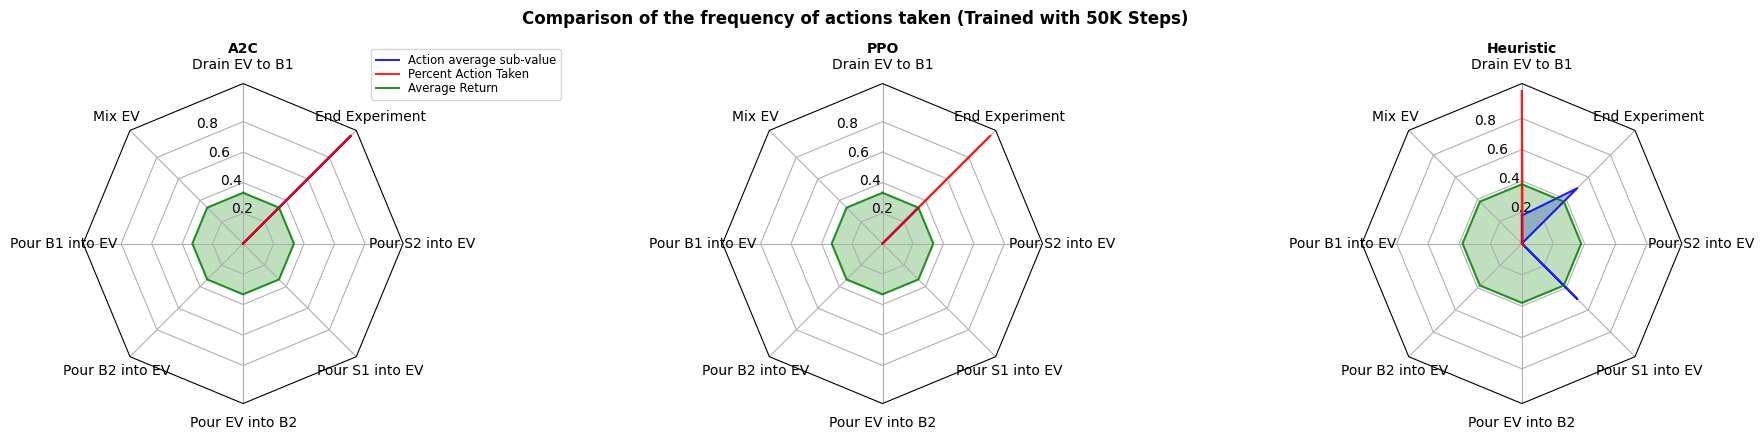

In [112]:
theta = radar_factory(len(info[0]), frame='polygon')
fig, axs = plt.subplots(figsize=(22, 4), nrows=1, ncols=len(models)+1,subplot_kw=dict(projection='radar'))
fig.subplots_adjust(wspace=0.5, hspace=0.25, top=0.85, bottom=0.05)
c=['b', 'r', 'g', 'm', 'y',"orange","r"]#[i:i+1]
make_radar(theta,axs,info,colors=c)
labels = ( 'Action average sub-value','Percent Action Taken',"Average Return")
legend = axs[0].legend(labels, loc=(0.9, .95),labelspacing=0.1, fontsize='small')
fig.text(0.5, 1.0, "Comparison of the frequency of actions taken (Trained with 50K Steps)",
             horizontalalignment='center', color='black', weight='bold',
             size='large')
plt.show()

# React Bench Training

In [19]:
for algo in ["PPO","SAC","A2C"]:
    os.system("python RLTrain.py algorithm=%s environment=GenWurtzReact-v1 steps=500000"%algo)
    
for algo in ["PPO","SAC","A2C"]:
    os.system("python RLTrain.py algorithm=%s environment=FictReact-v2 steps=500000"%algo)

# Extraction and Distillation Bench Training

In [ ]:
import os
#from RLTrain import ALGO
#print (ALGO)
for algo in ['PPO', 'A2C']:
    os.system("python RLTrain.py algorithm=%s environment=GenWurtzExtract-v1 steps=50000"%algo)
    os.system("python RLTrain.py algorithm=%s environment=WurtzDistill-v1 steps=50000"%algo)

In [21]:
for algo in ['PPO', 'A2C']:
    os.system("python RLTrain.py algorithm=%s environment=WurtzExtract-v1 steps=50000"%algo)

In [ ]:
algo = "A2C"
os.system("python RLTrain.py algorithm=%s environment=WurtzDistill-v1 steps=50000"%algo)

# Evaluation

In [23]:
import os

for a,b,c in os.walk("./"):
    #print(a)
    if "-v" in a and not "Legacy" in a:
        print(a[2:])
        os.system("python RLTest.py %s steps=5000"%a)

A2C_FictReact-v2
A2C_GenWurtzExtract-v1
A2C_GenWurtzReact-v1
A2C_WurtzDistill-v1
A2C_WurtzExtract-v1
PPO_FictReact-v2
PPO_GenWurtzExtract-v1
PPO_GenWurtzReact-v1
PPO_WurtzDistill-v1
PPO_WurtzExtract-v1
SAC_FictReact-v2
SAC_GenWurtzReact-v1


In [39]:
os.system("python RLTest.py WDH environment=WurtzDistill-v1 algorithm=WDH steps=5000")

0

In [2]:
for a in ["PPO_WurtzDistill-v1","A2C_WurtzDistill-v1"]:
    os.system("python RLTest.py %s steps=5000"%a)

In [67]:
os.system("python RLTest.py WEH environment=WurtzExtract-v1 algorithm=WEH steps=5000")

0

In [29]:
dheuristic = pd.read_pickle("WDH/rollout")
dheuristic[dheuristic.Done==True].Reward.mean()

0.0

In [46]:
eheuristic = pd.read_pickle("WEH/rollout")
eheuristic[dheuristic.Done==True].Reward.mean()

0.3785714844378682